## Phylogeny analysis

This notebook needs two dataset to run:
- The GISAID database (https://www.gisaid.org/) require scientific credentials and a login. The dataset used is in EpiCov → Download → spikeprot????. Save this one in Additional_data/whole_genome_sequencing/spikeprot????.fasta
- The COG global tree can be downloaded from [here](https://microreact.org/project/suVnc6aexZY5a7dWM6tcfs-global-sars-cov-2-2019-12-242022-02-11) (javascript app, really slow)



In [25]:
import pandas as pd
import ete3
import json
from Bio import SeqIO
from tqdm.notebook import tqdm
import pickle
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N',
                  'T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']


In [2]:
import regex as re


#load the sequences

rbds = {}
for record in SeqIO.parse("./../../Additional_data/whole_genome_sequencing/spikeprot0417.fasta", "fasta"):
    rbds[record.id] = str(record.seq)[330:531]

def omicron_mutations(s):
    bi = ''
    our_sequence = r"^NITNLCPF(G|D)EVFNATRFASVYAWNRKRISNCVADYSVLYN(S|L)A(S|P)F(S|F)TFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTG(K|N)IADYNYKLPDDFTGCVIAWNSN(N|K)LDSKV(G|S)GNYNYLYRLFRKSNLKPFERDISTEIYQAG(S|N)(T|K)PCNGV(E|A)GFNCYFPL(Q|R)SY(G|S)F(Q|R)PT(N|Y)GVG(Y|H)QPYRVVVLSFELLHAPATVCGPKKST$"
    if not re.match(our_sequence, s):
        return "X"*15
    
    mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
    for a in mutation_names:
        w, o, pos = a[0], a[-1], int(a[1:-1])
        if s[pos - 331] == w:
            bi += '0'
        elif s[pos - 331] == o:
            bi += '1'
        else:
            bi += 'X'
    return bi

muts = {}
for a in tqdm(rbds):
    if len(rbds[a]) == 201:
        bi = omicron_mutations(rbds[a])
        if 'X' not in bi:
            muts[a] = bi
        
import pickle
with open("gisaid_data_omicron_mutations.pkl", "wb") as fw:
    pickle.dump(muts, fw)


KeyboardInterrupt



In [6]:
with open("gisaid_data_omicron_mutations.pkl", "rb") as f:
    muts = pickle.load(f)

## tree recreation

In [19]:
import ete3
#t = ete3.Tree("cog_global_tree_public_pruned.newick")
t = ete3.Tree("cog_global_pruned_omicron.nw")

In [8]:
muts_nk = {}
for a in muts:
    s = a.split("|")[1][8:]
    if s != '':
        muts_nk[s] = muts[a]

In [9]:
validkey = set([a.name for a in t.traverse()]) & set(list(muts_nk.keys()))

In [12]:
t.write(format=1, outfile="cog_global_pruned_omicron.nw")

In [20]:
for a in t.traverse():
    a.add_features(binary=muts_nk[a.name] if a.name in muts_nk else '')

In [60]:

t.binary

'000000000000000'

In [59]:
t.binary = '0'*15
for a in t.traverse("preorder"):
    for c in a.children:
        if c.binary == '':
            c.binary = a.binary

In [69]:
from collections import defaultdict
sources, targets =  [], []
for a in t.traverse():
    for c in a.children:
        if c.binary != a.binary:
            sources += [a.binary]
            targets += [c.binary]
df = pd.DataFrame()
df["source"] = sources
df["target"] = targets

In [72]:
df.target.value_counts()

000000010000000    10979
000000000000010     8495
000000001000000     7134
000001000000000     2002
111111111111111      796
                   ...  
100000001000000        1
000111111110111        1
111100000010111        1
000000011000000        1
100010011001001        1
Name: target, Length: 99, dtype: int64

In [8]:
pure_ow, pure_ow_om, pure_ow_wu = {}, {}, {}
for a in tqdm(muts):
    if 'X' not in muts[a]:
        pure_ow[a] = muts[a]
        if muts[a].count('1') > muts[a].count('0'):
            pure_ow_om[a] = muts[a]
        elif muts[a].count('1') < muts[a].count('0'):
            pure_ow_wu[a] = muts[a]
        
print(len(pure_ow))

  0%|          | 0/9953535 [00:00<?, ?it/s]

870942


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'G339D'),
  Text(1, 0, 'S371L'),
  Text(2, 0, 'S373P'),
  Text(3, 0, 'S375F'),
  Text(4, 0, 'K417N'),
  Text(5, 0, 'N440K'),
  Text(6, 0, 'G446S'),
  Text(7, 0, 'S477N'),
  Text(8, 0, 'T478K'),
  Text(9, 0, 'E484A'),
  Text(10, 0, 'Q493R'),
  Text(11, 0, 'G496S'),
  Text(12, 0, 'Q498R'),
  Text(13, 0, 'N501Y'),
  Text(14, 0, 'Y505H')])

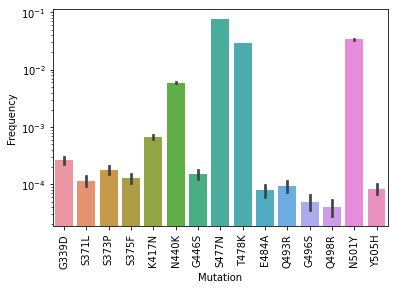

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seqs = np.array([[int(n) for n in pure_ow_wu[a] ] for a in pure_ow_wu])
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
df_wuf = pd.DataFrame()
for ii, m in enumerate(mutation_names):
    df_wuf[m] = seqs[:, ii]

g = sns.barplot(data=df_wuf.stack().reset_index().rename({"level_1": "Mutation", 0: "Frequency"}, axis=1),
            x="Mutation",
            y="Frequency")
g.set_yscale('log')
#plt.ylim((0., 0.1))
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'D339G'),
  Text(1, 0, 'L371S'),
  Text(2, 0, 'P373S'),
  Text(3, 0, 'F375S'),
  Text(4, 0, 'N417K'),
  Text(5, 0, 'K440N'),
  Text(6, 0, 'S446G'),
  Text(7, 0, 'N477S'),
  Text(8, 0, 'K478T'),
  Text(9, 0, 'A484E'),
  Text(10, 0, 'R493Q'),
  Text(11, 0, 'S496G'),
  Text(12, 0, 'R498Q'),
  Text(13, 0, 'Y501N'),
  Text(14, 0, 'H505Y')])

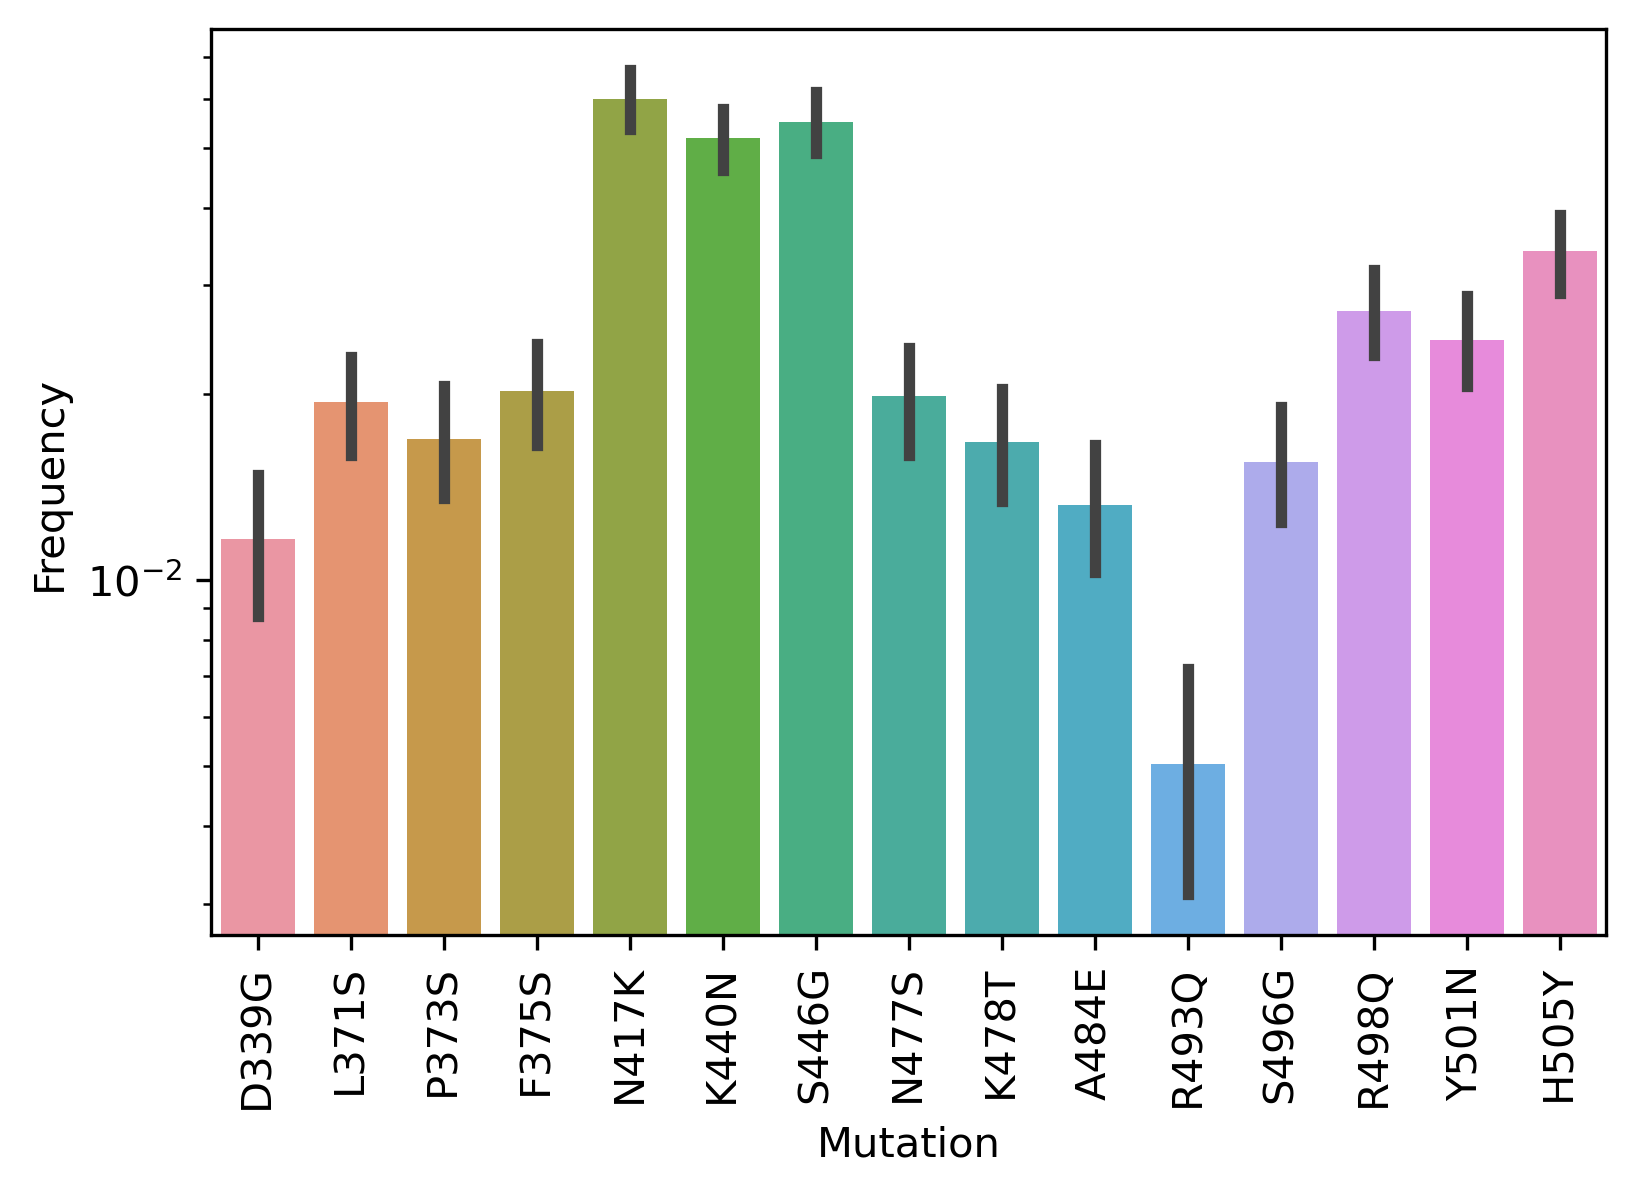

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seqs = np.array([[int(n) for n in pure_ow_om[a] ] for a in pure_ow_om])
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
df_omf = pd.DataFrame()
for ii, m in enumerate(mutation_names):
    df_omf[m[-1]+m[1:-1] + m[0]] = 1-seqs[:, ii]

g = sns.barplot(data=df_omf.stack().reset_index().rename({"level_1": "Mutation", 0: "Frequency"}, axis=1),
            x="Mutation",
            y="Frequency")
g.set_yscale('log')
#plt.ylim((0., 0.1))
plt.xticks(rotation = 90)

In [94]:
df_omf = df_omf.stack().reset_index().rename({"level_1": "Mutation", 0: "Frequency"}, axis=1)
df_omf = df_omf.groupby("Mutation").agg({'Frequency': ['mean', 'std']}).reset_index()
df_wuf = df_wuf.stack().reset_index().rename({"level_1": "Mutation", 0: "Frequency"}, axis=1)
df_wuf = df_wuf.groupby("Mutation").agg({'Frequency': ['mean', 'std']}).reset_index()


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300
L = 15
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']

df = pd.read_csv("../Titeseq/results_RBD_reindex/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'


## temporary measure, remove bad Kd
df.loc[df.geno.str[9:13] == "1000", "log10Kd"] = np.nan

import matplotlib.transforms as transforms
from tqdm.notebook import tqdm
dft = df.set_index("geno")
dfpl = pd.DataFrame()
kds = dft.log10Kd.to_dict()
errkds = dft.err_log10Kd.to_dict()
nbmuts, deltas, muts, keeps, deltas_err, sources, targets = [], [], [], [], [], [], []
for im, m in tqdm(enumerate(mutation_names)):
    muts += [m]*(len(df))
    for s in df.geno:
        deltas += [kds[s] - kds[s[:im] + '1' + s[im+1:]]]
        deltas_err += [np.sqrt(errkds[s]**2 + errkds[s[:im] + '1' + s[im+1:]]**2)]
        nbmuts += [s.count('1')]
        keeps += [s[im] != '1']
        sources += [s]
        targets += [s[:im] + '1' + s[im+1:]]

dfpl = pd.DataFrame()
dfpl["Mutation"] = muts
dfpl[r'$\Delta \log_{10}(K_d)$'] = deltas
dfpl[r'$\Delta \log_{10}(K_d)$'] = -dfpl[r'$\Delta \log_{10}(K_d)$']
dfpl[r'Number of mutations'] = nbmuts
dfpl[r'err_ΔKd'] = deltas_err
dfpl[r'source'] = sources
dfpl[r'target'] = sources
dfpl = dfpl[keeps]


0it [00:00, ?it/s]

In [103]:
df_wuhan

,Mutation,$\Delta \log_{10}(K_d)$,Number of mutations,err_ΔKd,source,target,frequency
0,G339D,-0.077541,0,0.079818,000000000000000,000000000000000,0.000263
32768,S371L,-0.088852,0,0.071623,000000000000000,000000000000000,0.000114
65536,S373P,-0.155853,0,0.070604,000000000000000,000000000000000,0.000176
98304,S375F,0.001074,0,0.085482,000000000000000,000000000000000,0.000127
131072,K417N,-0.531270,0,0.071326,000000000000000,000000000000000,0.000680
163840,N440K,0.057940,0,0.070775,000000000000000,000000000000000,0.005936
196608,G446S,-0.178311,0,0.102724,000000000000000,000000000000000,0.000152
229376,S477N,0.117606,0,0.103946,000000000000000,000000000000000,0.077189
262144,T478K,-0.038649,0,0.070623,000000000000000,000000000000000,0.029077
294912,E484A,NaN,0,0.077929,000000000000000,000000000000000,0.000079


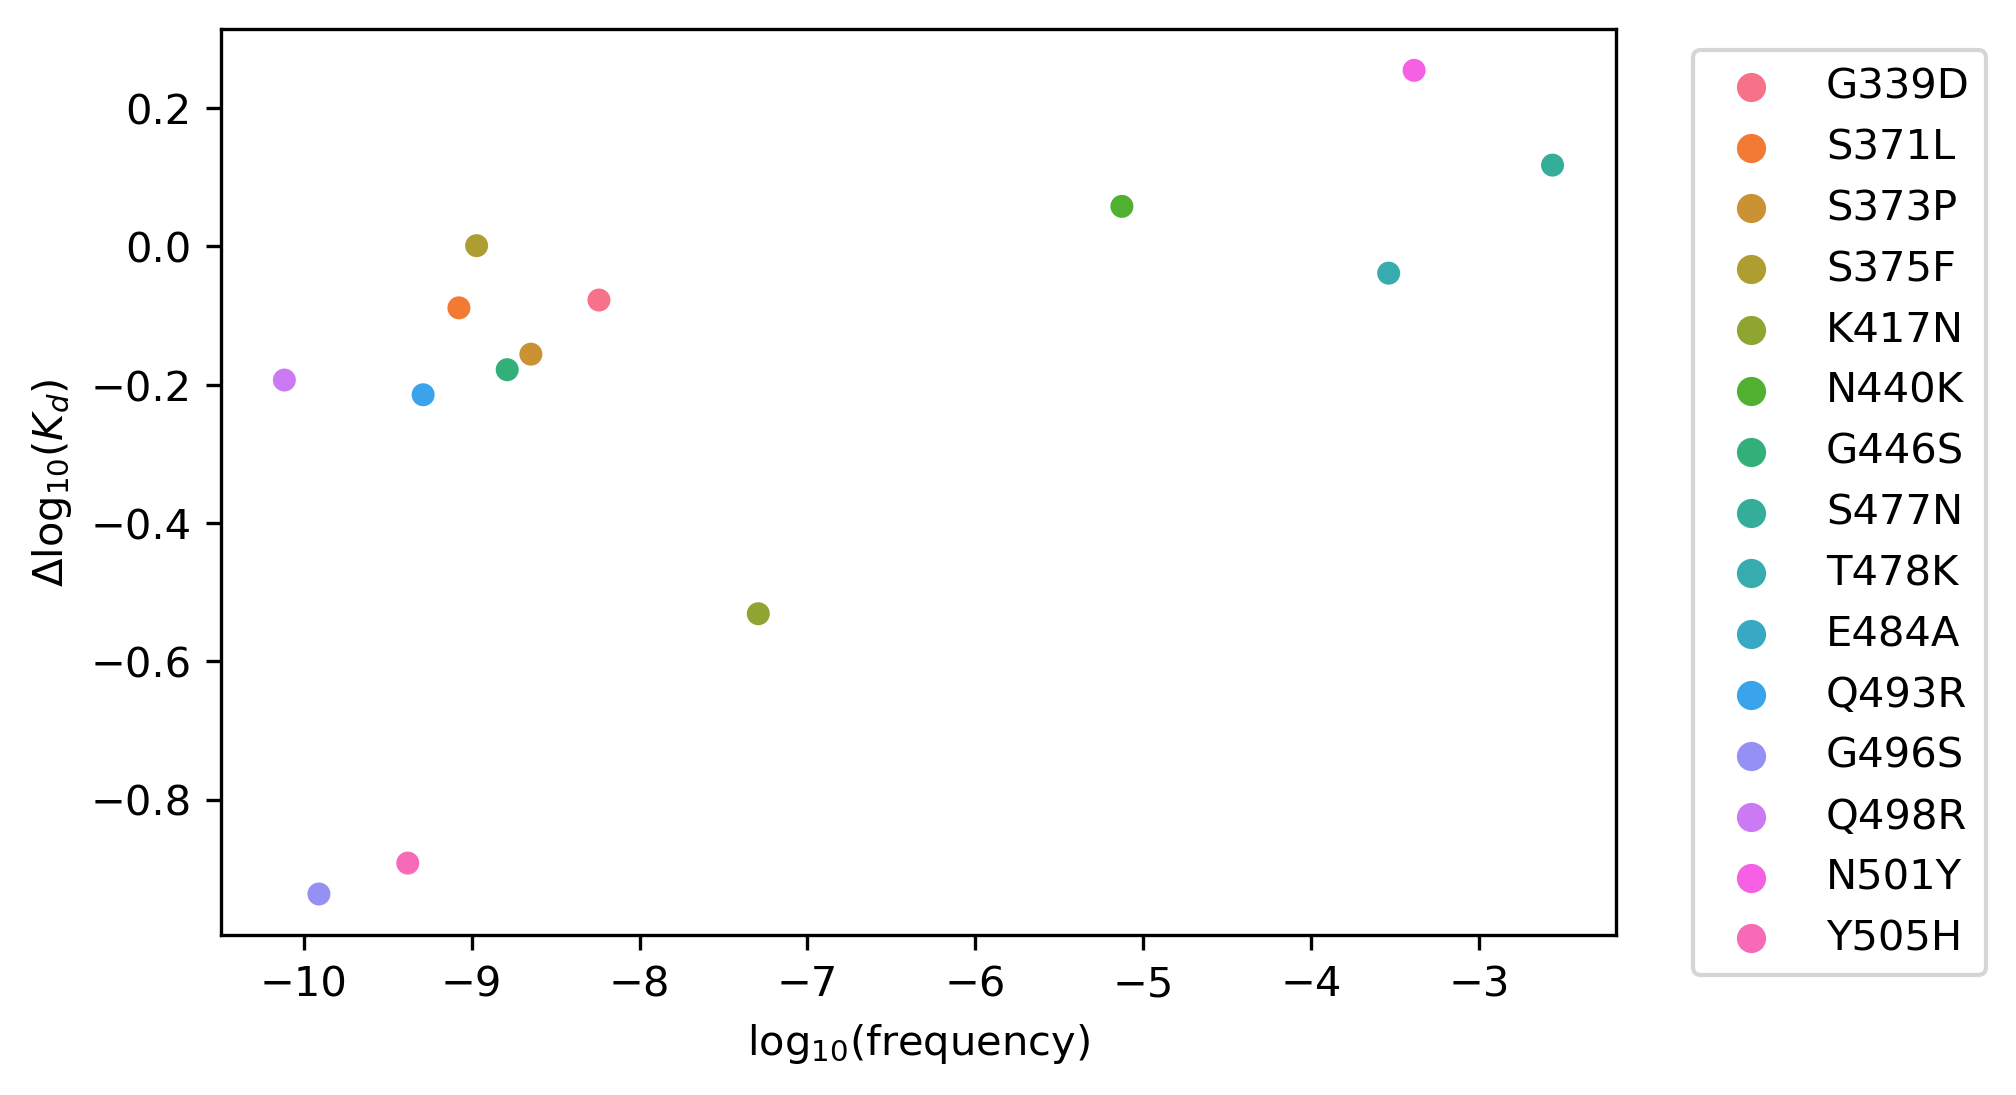

In [131]:
df_wuhan = dfpl[dfpl.source.str.count('1') == 0].copy()
df_wuhan[r'$\log_{10}(\mathrm{frequency})$'] = np.log(df_wuhan.Mutation.map(df_wuf.set_index("Mutation").Frequency["mean"]))
sns.scatterplot(x=df_wuhan[r'$\log_{10}(\mathrm{frequency})$'], 
                y=df_wuhan[r'$\Delta \log_{10}(K_d)$'], hue=df_wuhan.Mutation)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [111]:
df_omf.set_index("Mutation").Frequency["mean"]

Mutation
A484E    0.013212
D339G    0.011657
F375S    0.020206
H505Y    0.034000
K440N    0.051875
K478T    0.016709
L371S    0.019429
N417K    0.059841
N477S    0.019817
P373S    0.016903
R493Q    0.005051
R498Q    0.027200
S446G    0.054983
S496G    0.015543
Y501N    0.024480
Name: mean, dtype: float64

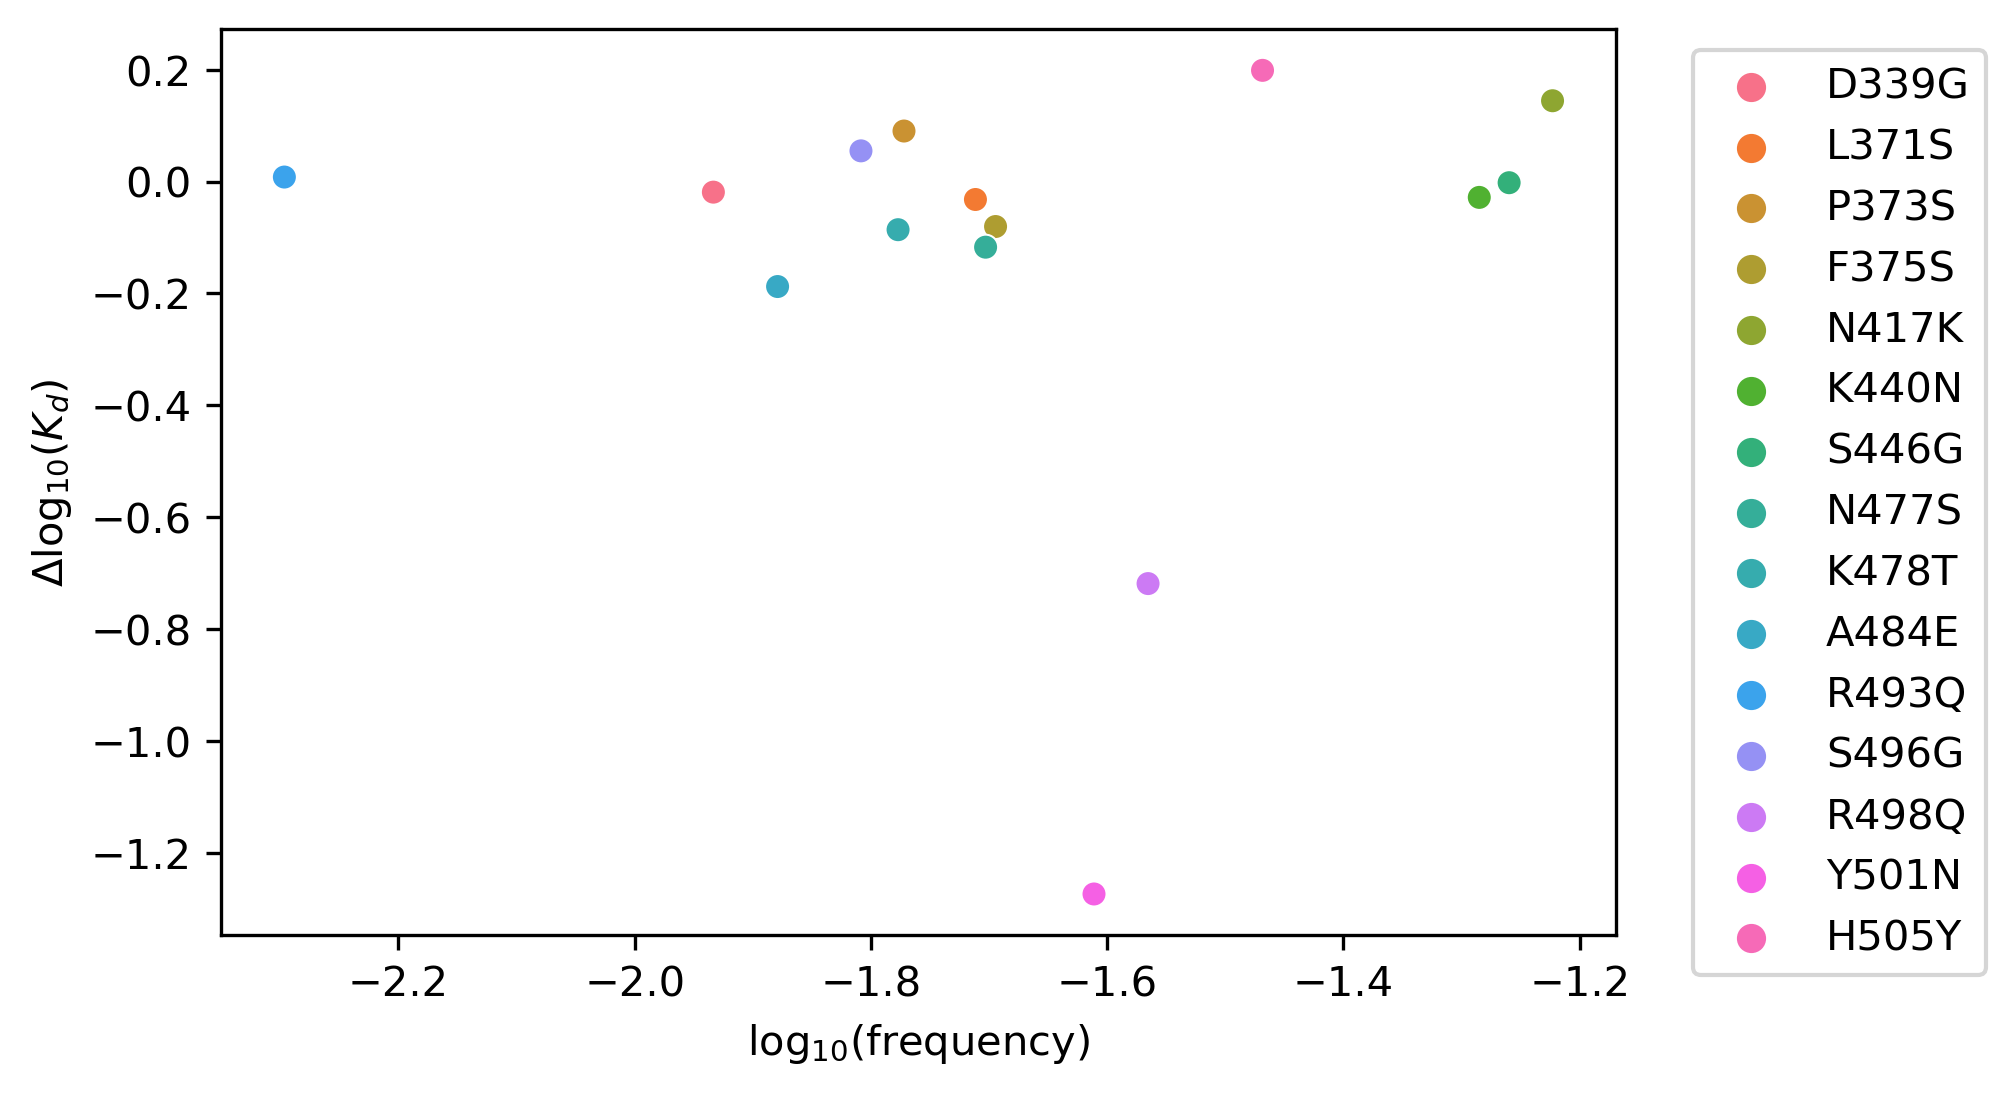

In [129]:
df_omicron = dfpl[dfpl.source.str.count('0') == 1].copy()
df_omicron[r'$\Delta \log_{10}(K_d)$'] = -df_omicron[r'$\Delta \log_{10}(K_d)$']
#df_omicron = df_omicron[~df_omicron.Mutation.isin(['N501Y', 'Q498R'])].copy()
df_omicron["Mutation"] = df_omicron["Mutation"].apply(lambda x: x[-1] + x[1:-1] + x[0])
df_omicron[r'$\log_{10}(\mathrm{frequency})$'] = np.log10(df_omicron.Mutation.map(df_omf.set_index("Mutation").Frequency["mean"]))
sns.scatterplot(x=df_omicron[r'$\log_{10}(\mathrm{frequency})$'],
                y=df_omicron[r'$\Delta \log_{10}(K_d)$'],
                hue=df_omicron.Mutation)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seqs = np.array([[int(n) for n in pure_ow_wu[a] ] for a in pure_ow_wu])
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
df_wuf = pd.DataFrame()
for ii, m in enumerate(mutation_names):
    df_wuf[m] = seqs[:, ii]


NameError: name 'pure_ow_wu' is not defined

In [144]:
df_wuf["Mutation Q498R"] = df_wuf["Q498R"].apply(str)
df_wuf["Mutation N501Y"] = df_wuf["N501Y"].apply(str)

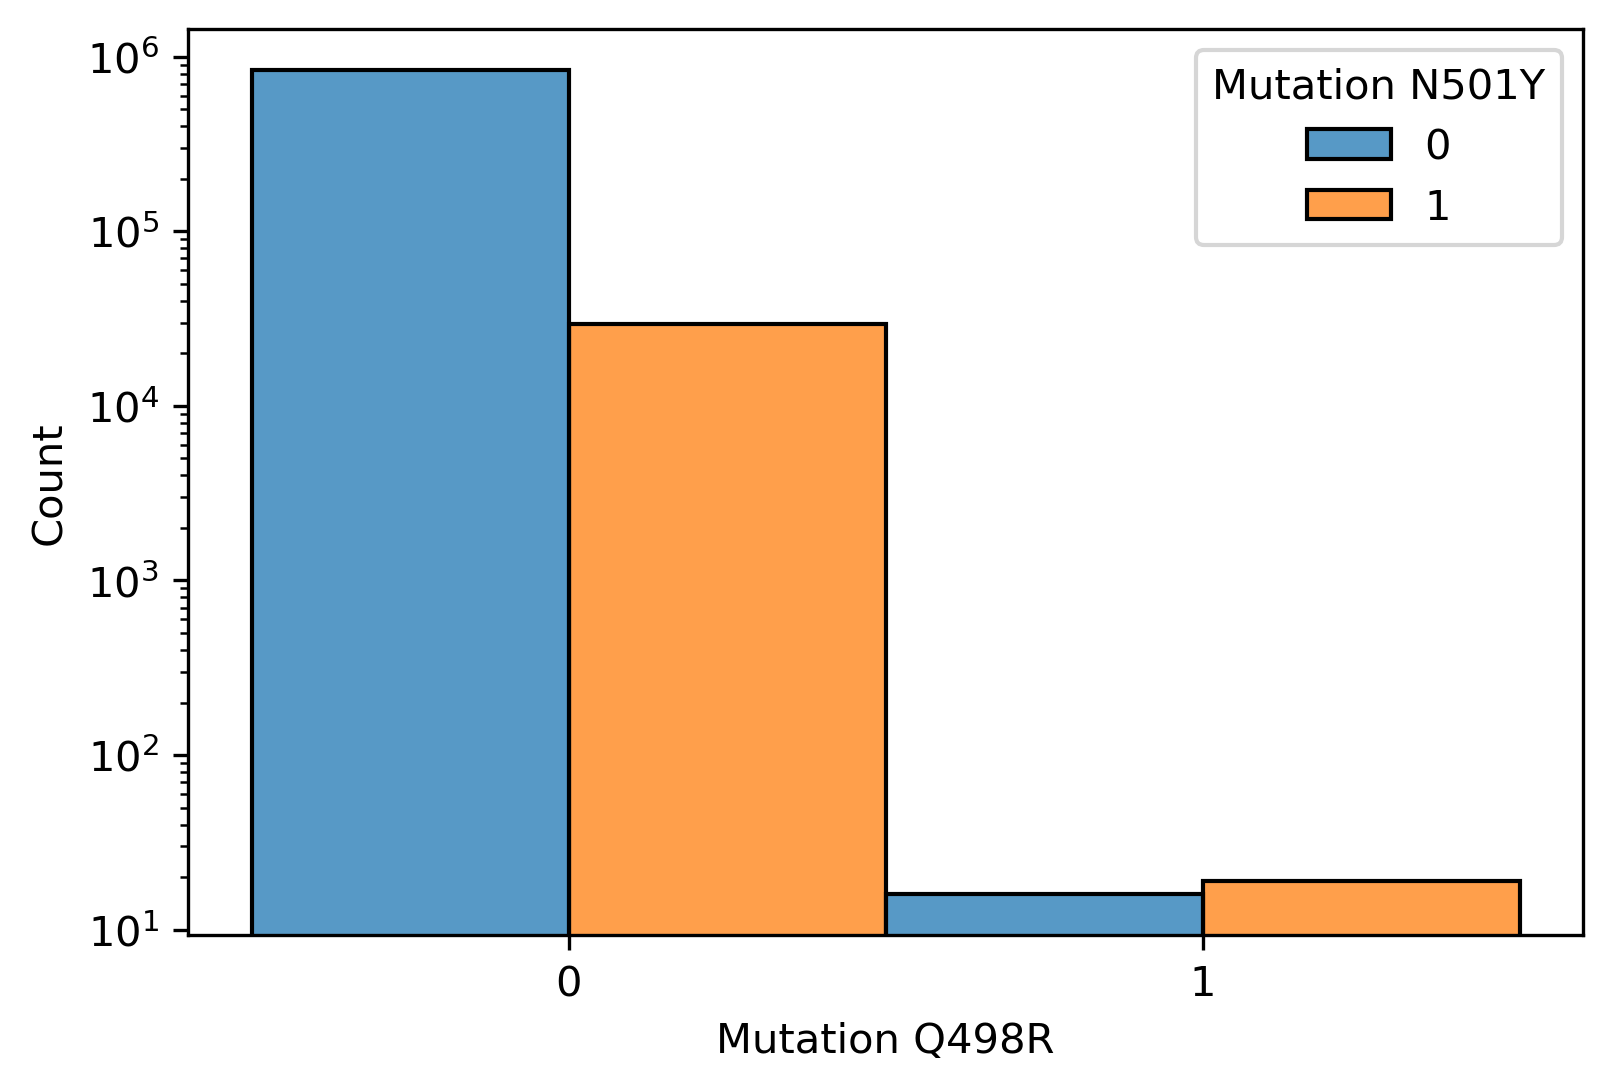

In [147]:
sns.histplot(data=df_wuf, x="Mutation Q498R", hue="Mutation N501Y", multiple='dodge').set_yscale('log')

In [12]:
# analyse of gisaid data

dfwu_concat = dfwuf

norm_proba = {}
for a in mutation_names:
    for b in mutation_names:
        if a != b:
            norm_proba[a, b] = (df_wuf[a]*df_wuf[b]).sum() / ((df_wuf[a]).sum() * df_wuf[b].sum()) * len(df_wuf)

In [8]:
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']


<AxesSubplot:xlabel='None-Mutation_2', ylabel='Mutation_1'>

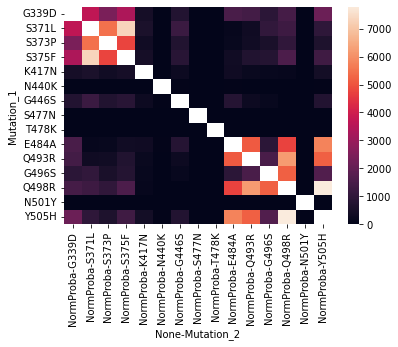

In [32]:

dfpl = pd.Series(norm_proba).rename_axis(['Mutation_1', 'Mutation_2']).reset_index(name='NormProba')
dfpl['Mutation_2'] = pd.Categorical(dfpl["Mutation_2"], 
                      categories=mutation_names,
                      ordered=True)
dfpl['Mutation_1'] = pd.Categorical(dfpl["Mutation_1"], 
                      categories=mutation_names,
                      ordered=True)
dfpl = dfpl.sort_values(['Mutation_1', 'Mutation_2'])
sns.heatmap(dfpl.pivot('Mutation_1', 'Mutation_2'))

In [62]:
from collections import Counter
seqs = Counter(pure_ow_wu.values())
L=15
# analyse of gisaid data

norm_proba = {}
for ii, a in enumerate(mutation_names):
    for jj, b in enumerate(mutation_names):
        if a != b:
            sa = '0'*(ii) + '1' + '0'*(L-ii-1)
            sb = '0'*(jj) + '1' + '0'*(L-jj-1)
            sab = f"{int(sa, 2) | int(sb, 2):015b}"
            if (seqs[sa] == 0 or seqs[sb] == 0 or seqs[sab] == 0):
                norm_proba[a, b] = np.nan
            else:
                norm_proba[a, b] = np.log(seqs[sab]/(seqs[sa]*seqs[sb]))

<AxesSubplot:xlabel='None-Mutation_2', ylabel='Mutation_1'>

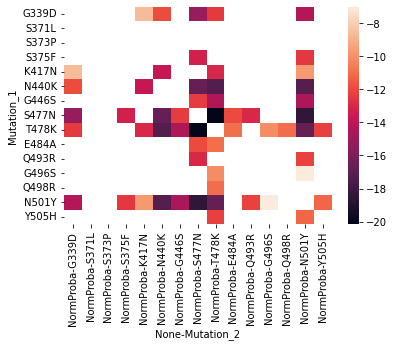

In [63]:

dfpl = pd.Series(norm_proba).rename_axis(['Mutation_1', 'Mutation_2']).reset_index(name='NormProba')
dfpl['Mutation_2'] = pd.Categorical(dfpl["Mutation_2"], 
                      categories=mutation_names,
                      ordered=True)
dfpl['Mutation_1'] = pd.Categorical(dfpl["Mutation_1"], 
                      categories=mutation_names,
                      ordered=True)
dfpl = dfpl.sort_values(['Mutation_1', 'Mutation_2'])
sns.heatmap(dfpl.pivot('Mutation_1', 'Mutation_2'))

In [1]:
import ete3
t = ete3.Tree("cog_global_tree_public_pruned.newick")

In [4]:
len(t)

4288515

In [6]:
for a in t:
    print(a)
    break


--Wuhan/WH04/2020


In [13]:
a = [a for a in t][0]

In [2]:
t.prune(list(rbds_nk.keys()))

NameError: name 'rbds_nk' is not defined

In [32]:
allowed_seq = list(set(rbds_nk.keys()) & set(a.name for a in t))

In [ ]:
t.prune(allowed_seq)